In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro
from collections import OrderedDict

In [2]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/'

In [3]:
from tools_lnd import take_names

def var_x_epoch(m,n_components = 100, timing_sort=True):

    h_all_byepoch, h_all_byrule, rules, h_all_timing =  make_h_all(m,mode = 'test',rules = [])
    
    keys = h_all_byepoch.keys()
    var_test = np.empty((len(keys),len(keys),n_components))
    var_test_sort = np.empty((len(keys),len(keys),n_components))

    for key_i in range(len(keys)):

        key = keys[key_i]

        h_tf = h_all_byepoch[key]
        x = np.transpose(h_tf,(2,1,0)) #h_tf[:,range(1,n_trials),:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))

        pca = PCA(n_components = n_components)
        _ = pca.fit_transform(X.T)

        for key_test_i in range(len(keys)):

            key_test = keys[key_test_i]

            h_test = h_all_byepoch[key_test]
            x = np.transpose(h_test,(2,1,0)) #h_tf[:,range(1,n_trials),:],(2,1,0))
            X_test = np.reshape(x,(x.shape[0],-1))

            var = np.var(np.dot(pca.components_,X_test),axis = 1)
            var_test[key_i,key_test_i,:] = var/np.sum(var)
            
    if timing_sort==True:
        epoch_order = np.argsort(h_all_timing)#[2,1,3,0,6,5,7,4]
    else:
        epoch_order = range(len(h_all_timing))

    for e1 in range(len(epoch_order)):
        for e2 in range(len(epoch_order)):
            var_test_sort[e1,e2,:] = var_test[epoch_order[e1],epoch_order[e2],:]
                
    tick_labels = []
    for e in epoch_order:
        epoch_name, rule_name, _, _ = take_names(keys[e][1],keys[e][0])
        key_str = rule_name[6:]+ ' ' + epoch_name

        tick_labels.append(key_str)
        
    return var_test_sort, tick_labels, keys

In [4]:
var_test_sort, tick_labels, keys = var_x_epoch(m, n_components = 100, timing_sort=True)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


In [9]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    hp = model.hp

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


In [10]:
hp

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': 0.0,
 u'l1_weight': 0.0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.00031622776601683794,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 20,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 15,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'out_type': u'all',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7fc5c0635e60>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [0.5, 0.5],
 u'rule_start': 5,
 u'rule_trains': [u'delaygo', u'delayanti'],
 u'rules': [u'delaygo', u'delayanti'],
 u'ruleset': u'all',
 u'save_name': u'test',
 u'seed': 0,
 u'sigma_rec': 0.05,
 u'sigma_x': 0.1,
 u'target_cost': 0,
 u'target_perf': 1.0,
 u'tau': 100,
 u'use_separate_input': False,
 u'w_rec_init': u'diag'}

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt


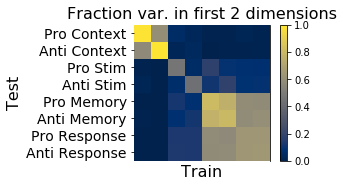

In [12]:
var_test_sort, tick_labels, keys = var_x_epoch(m, n_components = 100, timing_sort=True)

tick_labels = ['Pro Context',
 'Anti Context',
 'Pro Stim',
 'Anti Stim',
 'Pro Memory',
 'Anti Memory',
 'Pro Response',
 'Anti Response']

n_dims = 2
fig = plt.figure(figsize=(4.5,2.7),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

plt.imshow(np.sum(var_test_sort[:,:,:n_dims],axis = 2),cmap = 'cividis')

ax.set_xlabel('Train', fontsize = 16)
ax.set_ylabel('Test', fontsize = 16)

ax.set_xticks([])
plt.title('Fraction var. in first '+ str(n_dims) + ' dimensions', fontsize = 16)
c = plt.colorbar()
c.outline.set_visible(False)

plt.clim(0, 1) 
ax.set_yticks(range(len(keys)))
ax.set_yticklabels(tick_labels, fontsize = 14)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()

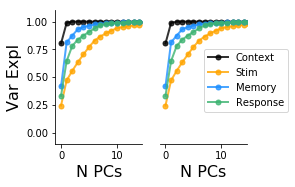

In [13]:
n_dims = 5
fig = plt.figure(figsize=(4,2.7),tight_layout=True,facecolor='white')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cmap = ['k','k','orange','orange','dodgerblue','dodgerblue','mediumseagreen','mediumseagreen']

for x in range(0,len(var_test_sort),2):
    ax1.plot(np.cumsum(var_test_sort[x,x,:]),'.-',c = cmap[x],alpha = .8,linewidth = 2,markersize = 10)
    
    
ax1.set_xlabel('N PCs', fontsize = 16)
ax1.set_ylabel('Var Expl', fontsize = 16)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlim([-1,14.5])
ax1.set_ylim([-.1,1.1])

    
for x in range(0,len(var_test_sort),2):
    ax2.plot(np.cumsum(var_test_sort[x,x,:]),'.-',label = tick_labels[x][4:],
             c = cmap[x],alpha = .8,linewidth = 2,markersize = 10)

ax2.set_xlabel('N PCs', fontsize = 16)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlim([-1,14.5])
ax2.set_ylim([-.1,1.1])
plt.legend(bbox_to_anchor=(.45, 0.75))


plt.show()

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/1024_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.0_sig_x0.0_w_rec_coeff_0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/1024_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.0_sig_x0.0_w_rec_coeff_0.8_delaygo_delayanti/3/model.ckpt


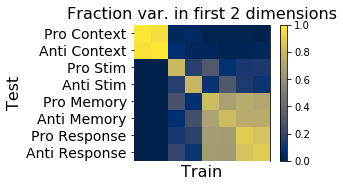

In [15]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/1024_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.0_sig_x0.0_w_rec_coeff_0.8_delaygo_delayanti/3'

var_test_sort, tick_labels, keys = var_x_epoch(m, n_components = 100, timing_sort=True)

tick_labels = ['Pro Context',
 'Anti Context',
 'Pro Stim',
 'Anti Stim',
 'Pro Memory',
 'Anti Memory',
 'Pro Response',
 'Anti Response']

n_dims = 2
fig = plt.figure(figsize=(4.5,2.7),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

plt.imshow(np.sum(var_test_sort[:,:,:n_dims],axis = 2),cmap = 'cividis')

ax.set_xlabel('Train', fontsize = 16)
ax.set_ylabel('Test', fontsize = 16)

ax.set_xticks([])
plt.title('Fraction var. in first '+ str(n_dims) + ' dimensions', fontsize = 16)
c = plt.colorbar()
c.outline.set_visible(False)

plt.clim(0, 1) 
ax.set_yticks(range(len(keys)))
ax.set_yticklabels(tick_labels, fontsize = 14)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

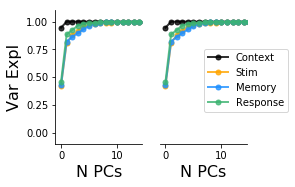

In [16]:
n_dims = 5
fig = plt.figure(figsize=(4,2.7),tight_layout=True,facecolor='white')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cmap = ['k','k','orange','orange','dodgerblue','dodgerblue','mediumseagreen','mediumseagreen']

for x in range(0,len(var_test_sort),2):
    ax1.plot(np.cumsum(var_test_sort[x,x,:]),'.-',c = cmap[x],alpha = .8,linewidth = 2,markersize = 10)
    
    
ax1.set_xlabel('N PCs', fontsize = 16)
ax1.set_ylabel('Var Expl', fontsize = 16)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlim([-1,14.5])
ax1.set_ylim([-.1,1.1])

    
for x in range(0,len(var_test_sort),2):
    ax2.plot(np.cumsum(var_test_sort[x,x,:]),'.-',label = tick_labels[x][4:],
             c = cmap[x],alpha = .8,linewidth = 2,markersize = 10)

ax2.set_xlabel('N PCs', fontsize = 16)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlim([-1,14.5])
ax2.set_ylim([-.1,1.1])
plt.legend(bbox_to_anchor=(.45, 0.75))


plt.show()

In [17]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    hp = model.hp

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(1044, 1024) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(1024, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/1024_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.0_sig_x0.0_w_rec_coeff_0.8_delaygo_delayanti/3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/1024_n_rnn/lr7.0l2_w6.0_h6.0_sig_rec0.0_sig_x0.0_w_rec_coeff_0.8_delaygo_delayanti/3/model.ckpt


In [18]:
hp

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': 0.0,
 u'l1_weight': 0.0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.00031622776601683794,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 20,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 1024,
 u'n_rule': 15,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'out_type': u'all',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7fc578ce9eb0>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [0.5, 0.5],
 u'rule_start': 5,
 u'rule_trains': [u'delaygo', u'delayanti'],
 u'rules': [u'delaygo', u'delayanti'],
 u'ruleset': u'all',
 u'save_name': u'test',
 u'seed': 3,
 u'sigma_rec': 0.0,
 u'sigma_x': 0.0,
 u'target_cost': 0,
 u'target_perf': 1.0,
 u'tau': 100,
 u'use_separate_input': False,
 u'w_rec_init': u'diag'}